## Setup 

The two datasets in the project consists of the hourly sales and traffic of a store in the US.

The objective is to make a model to identify the sales and traffic per hour for the following month. 

> ## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from tensorflow.keras.layers import Bidirectional, LSTM
print('Setup Complete.')

Setup Complete.


### Read in the data

> **Sales Data**

In [71]:
df_sales = pd.read_csv('https://raw.githubusercontent.com/HuanLei07/TimeSeriesVisualization/main/training_Sales.csv')

print(df_sales.shape)
df_sales.head()

(67058, 2)


,Date,Value
0,2013-11-07 13:00:00,830
1,2013-11-07 13:15:00,885
2,2013-11-07 13:30:00,938
3,2013-11-07 13:45:00,804
4,2013-11-07 14:00:00,793


> **Traffic**

In [72]:
df_traffic = pd.read_csv('https://raw.githubusercontent.com/HuanLei07/TimeSeriesVisualization/main/training_Traffic.csv')

# Convert the Time column to datatime format 
print(df_traffic.shape)
df_traffic.head()

(58437, 2)


,Date,Value
0,2015-01-01 10:00:00,0
1,2015-01-01 10:15:00,1
2,2015-01-01 10:30:00,4
3,2015-01-01 10:45:00,3
4,2015-01-01 11:00:00,1


### Data Preparation

> **Sales**

In [4]:
df_sales = df_sales.rename(columns = {"Value": "value"})

In [5]:
# convert Date column to datetime type
df_sales['DateTime'] = pd.to_datetime(df_sales.Date)

In [6]:
df_sales.head()

,Date,value,DateTime
0,2013-11-07 13:00:00,830,2013-11-07 13:00:00
1,2013-11-07 13:15:00,885,2013-11-07 13:15:00
2,2013-11-07 13:30:00,938,2013-11-07 13:30:00
3,2013-11-07 13:45:00,804,2013-11-07 13:45:00
4,2013-11-07 14:00:00,793,2013-11-07 14:00:00


In [7]:
# resample to hourly 
df_sales_hourly = df_sales.set_index('DateTime').resample('60min').sum()

In [8]:
# add holiday data into the dataframe 
dr_sales = pd.date_range(start = '2013-11-07', end = '2018-05-06')

cal_sales = calendar()
holidays_sales = cal_sales.holidays(start = dr_sales.min(),
                                   end = dr_sales.max())

df_sales_hourly['holiday'] = df_sales_hourly.index.isin(holidays_sales)

In [9]:
df_sales_hourly['date'] = df_sales_hourly.index.date
df_sales_hourly['time'] = df_sales_hourly.index.time

In [10]:
df_sales_hourly.head()
df_sales_hourly.shape

(39391, 4)

> **Traffic**

In [11]:
df_traffic = df_traffic.rename(columns = {"Value": "value"})

In [12]:
# convert Date column to datetime type
df_traffic['DateTime'] = pd.to_datetime(df_traffic.Date)

In [13]:
# resample to hourly 
df_traffic_hourly = df_traffic.set_index('DateTime').resample('60min').sum()

In [14]:
# add holiday data into the dataframe 
dr_traffic = pd.date_range(start = '2015-01-01', end = '2018-05-06')

cal_traffic = calendar()
holidays_traffic = cal_traffic.holidays(start = dr_traffic.min(), 
                                        end = dr_traffic.max())

df_traffic_hourly['holiday'] = df_traffic_hourly.index.isin(holidays_traffic)

In [15]:
df_traffic_hourly['date'] = df_traffic_hourly.index.date
df_traffic_hourly['time'] = df_traffic_hourly.index.time

In [16]:
df_traffic_hourly.head()
df_traffic_hourly.shape

(29316, 4)

## Impute Missing Data

> **Sales**

In [17]:
print('Start dt: ', df_sales_hourly.index.min())
print('End dt: ', df_sales_hourly.index.max())

Start dt:  2013-11-07 13:00:00
End dt:  2018-05-06 19:00:00


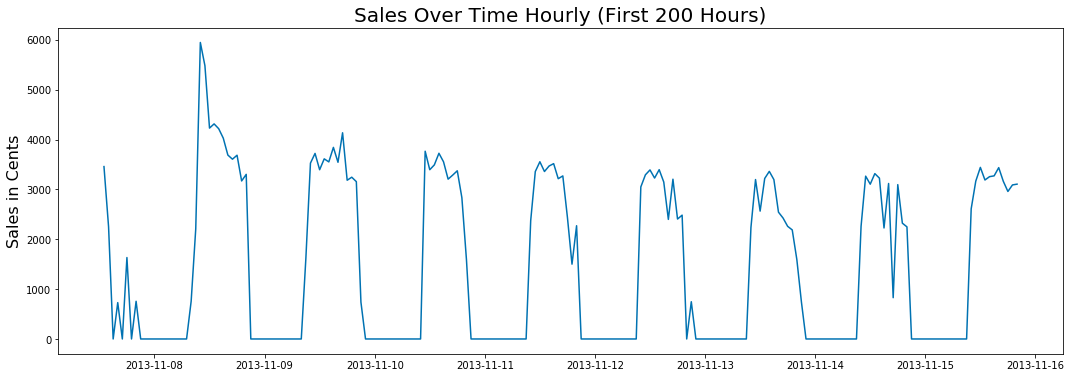

In [18]:
plt.style.use('seaborn-colorblind')
plt.figure(figsize = (18, 6))

plt.title('Sales Over Time Hourly (First 200 Hours)', fontsize = 20)
plt.ylabel('Sales in Cents', fontsize = 16)
# plt.plot(df_sales['Value'])
plt.plot(df_sales_hourly.index[0: 200], df_sales_hourly['value'][0: 200])

plt.show()

In [19]:
(df_sales_hourly == 0).astype(int).sum()

value      20571
holiday    39345
date           0
time           0
dtype: int64

In [20]:
df_sales_hourly[df_sales_hourly['value'] == 0]

,value,holiday,date,time
DateTime,,,,
2013-11-07 15:00:00,0,False,2013-11-07,15:00:00
2013-11-07 17:00:00,0,False,2013-11-07,17:00:00
2013-11-07 19:00:00,0,False,2013-11-07,19:00:00
2013-11-07 21:00:00,0,False,2013-11-07,21:00:00
2013-11-07 22:00:00,0,False,2013-11-07,22:00:00
...,...,...,...,...
2018-05-06 06:00:00,0,False,2018-05-06,06:00:00
2018-05-06 07:00:00,0,False,2018-05-06,07:00:00
2018-05-06 08:00:00,0,False,2018-05-06,08:00:00


From the first 200 data points in sales data and the values shown above, there are 20571 hours with missing values. The sales data has seasonality, but no trend. Replace '0' with the mean of value in corresponding hours.

In [21]:
# replace missing values with mean values of corresponding hours
for row in range(len(df_sales_hourly['value'])):
    if df_sales_hourly['value'][row] == 0:
        df_sales_hourly['value'][row] = df_sales_hourly['value'][df_sales_hourly['time'] == df_sales_hourly['time'][row]].mean()  

/Users/huanlei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


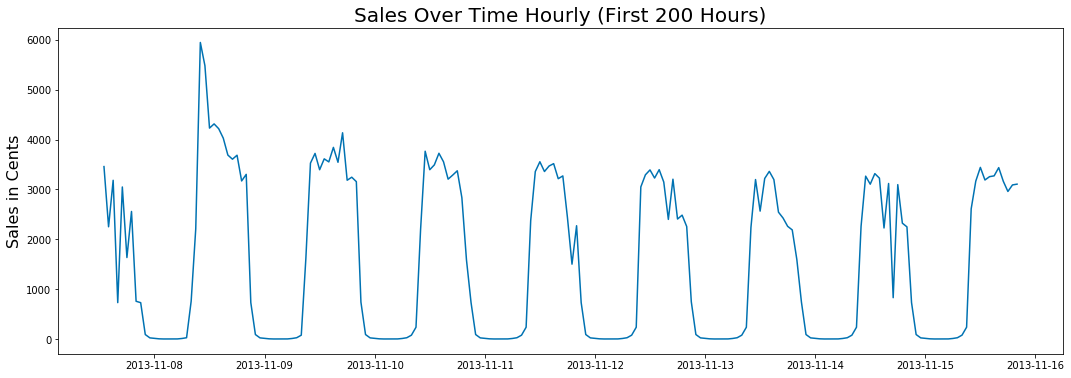

In [22]:
## After handling missing data in Sales
# Plot values after handling missing data
plt.style.use('seaborn-colorblind')
plt.figure(figsize = (18, 6))

plt.title('Sales Over Time Hourly (First 200 Hours)', fontsize = 20)
plt.ylabel('Sales in Cents', fontsize = 16)
# plt.plot(df_sales['Value'])
plt.plot(df_sales_hourly.index[0: 200], df_sales_hourly['value'][0: 200])

plt.show()

In [23]:
(df_sales_hourly == 0).astype(int).sum()

value       4923
holiday    39345
date           0
time           0
dtype: int64

In [24]:
df_sales_hourly[df_sales_hourly['value'] == 0]

,value,holiday,date,time
DateTime,,,,
2013-11-08 02:00:00,0,False,2013-11-08,02:00:00
2013-11-08 03:00:00,0,False,2013-11-08,03:00:00
2013-11-08 04:00:00,0,False,2013-11-08,04:00:00
2013-11-09 02:00:00,0,False,2013-11-09,02:00:00
2013-11-09 03:00:00,0,False,2013-11-09,03:00:00
...,...,...,...,...
2018-05-05 03:00:00,0,False,2018-05-05,03:00:00
2018-05-05 04:00:00,0,False,2018-05-05,04:00:00
2018-05-06 02:00:00,0,False,2018-05-06,02:00:00


After replacing 0 values in the dataset, there are 4923 data points with `value = 0`, which range from 02:00:00 - 04:00:00. Given the fact that people rarely shop between these hours, `value = 0` is Ok to have in the data. 

> **Traffic Data**

In [25]:
print('Start dt: ', df_traffic_hourly.index.min())
print('End dt: ', df_traffic_hourly.index.max())

Start dt:  2015-01-01 10:00:00
End dt:  2018-05-06 21:00:00


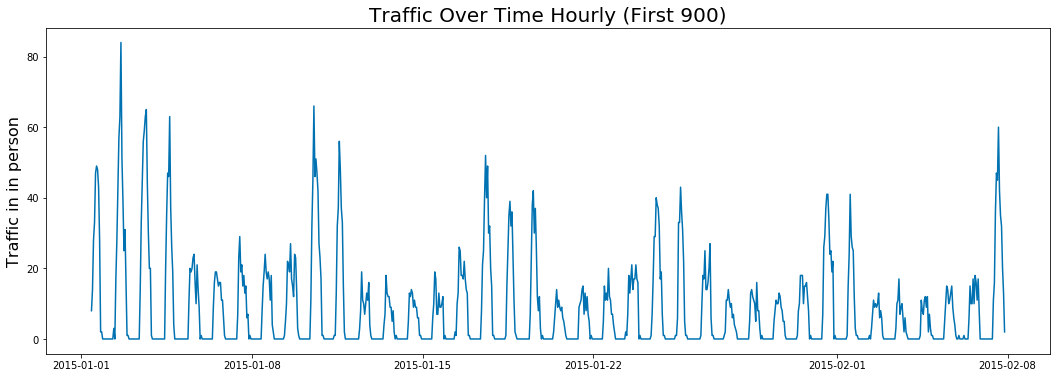

In [26]:
# before handling missing data
plt.style.use('seaborn-colorblind')
plt.figure(figsize = (18, 6))

plt.title('Traffic Over Time Hourly (First 900)', fontsize = 20)
plt.ylabel('Traffic in in person', fontsize = 16)
# plt.plot(df_sales['Value'])
plt.plot(df_traffic_hourly.index[0: 900], df_traffic_hourly['value'][0: 900])

plt.show()

In [27]:
(df_traffic_hourly == 0).astype(int).sum()

value      13860
holiday    29284
date           0
time           0
dtype: int64

In [28]:
df_traffic_hourly[df_traffic_hourly['value'] == 0]

,value,holiday,date,time
DateTime,,,,
2015-01-01 21:00:00,0,False,2015-01-01,21:00:00
2015-01-01 22:00:00,0,False,2015-01-01,22:00:00
2015-01-01 23:00:00,0,False,2015-01-01,23:00:00
2015-01-02 00:00:00,0,False,2015-01-02,00:00:00
2015-01-02 01:00:00,0,False,2015-01-02,01:00:00
...,...,...,...,...
2018-05-06 07:00:00,0,False,2018-05-06,07:00:00
2018-05-06 08:00:00,0,False,2018-05-06,08:00:00
2018-05-06 09:00:00,0,False,2018-05-06,09:00:00


From the first 900 data points in traffic data and the values shown above, there are 13860 hours with missing values. The sales data has seasonality, but no trend. Replace '0' with the mean of value in corresponding hours.

In [29]:
# replace missing values with mean values of corresponding hours
for row in range(len(df_traffic_hourly['value'])):
    if df_traffic_hourly['value'][row] == 0:
        df_traffic_hourly['value'][row] = df_traffic_hourly['value'][df_traffic_hourly['time'] == df_traffic_hourly['time'][row]].mean() 
        

/Users/huanlei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


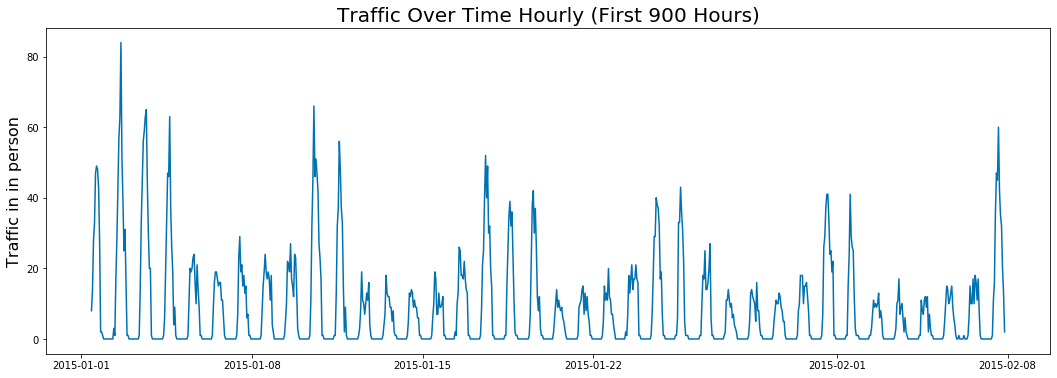

In [30]:
# Plot values after handling missing data
plt.style.use('seaborn-colorblind')
plt.figure(figsize = (18, 6))

plt.title('Traffic Over Time Hourly (First 900 Hours)', fontsize = 20)
plt.ylabel('Traffic in in person', fontsize = 16)
# plt.plot(df_sales['Value'])
plt.plot(df_traffic_hourly.index[0: 900], df_traffic_hourly['value'][0: 900])

plt.show()

In [31]:
(df_traffic_hourly == 0).astype(int).sum()

value      12280
holiday    29284
date           0
time           0
dtype: int64

In [32]:
df_traffic_hourly[df_traffic_hourly['value'] == 0]

,value,holiday,date,time
DateTime,,,,
2015-01-01 22:00:00,0,False,2015-01-01,22:00:00
2015-01-01 23:00:00,0,False,2015-01-01,23:00:00
2015-01-02 00:00:00,0,False,2015-01-02,00:00:00
2015-01-02 01:00:00,0,False,2015-01-02,01:00:00
2015-01-02 02:00:00,0,False,2015-01-02,02:00:00
...,...,...,...,...
2018-05-06 04:00:00,0,False,2018-05-06,04:00:00
2018-05-06 05:00:00,0,False,2018-05-06,05:00:00
2018-05-06 06:00:00,0,False,2018-05-06,06:00:00


After replacing `value = 0`, there are 12280 hours with `value = 0` between 22:00:00 - 08:00:00.

## Model Selection

### ETS

> **Sales**

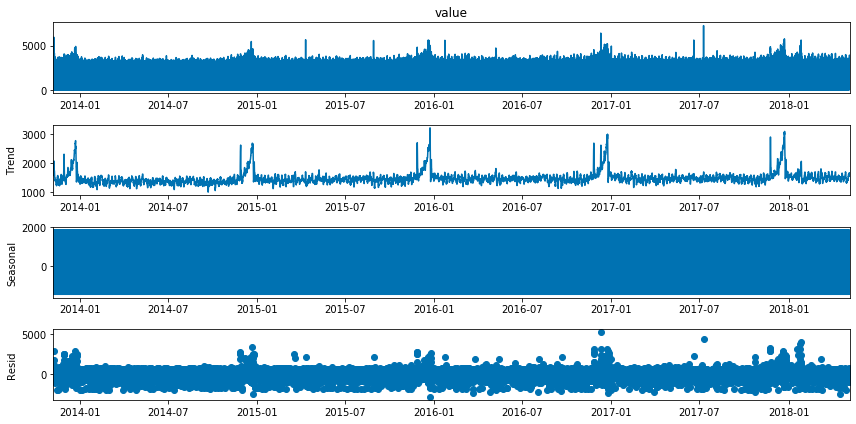

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

result_sales = seasonal_decompose(df_sales_hourly['value'])
rcParams['figure.figsize'] = 12, 6
result_sales.plot();

There are several spikes among the year, but we could clearly see the tremendous spikes during around Thanksgiving & Christmas shopping season. From the residuals, we could detect the outliers and anamoly in the data, which corresponds to the seasonality in the data. 

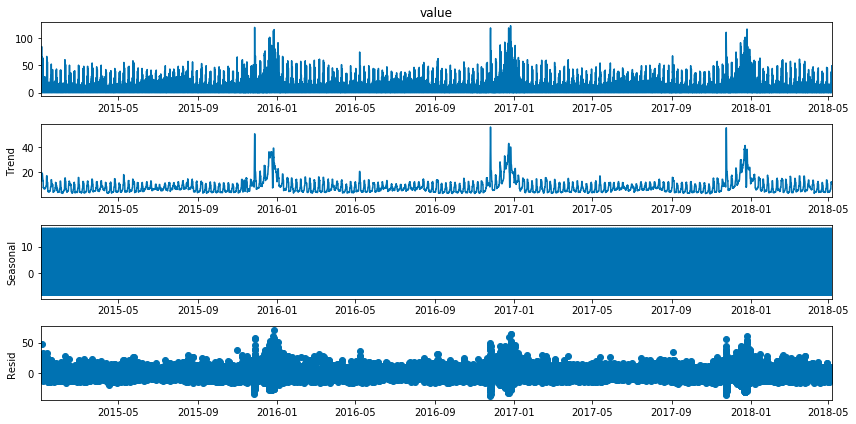

In [34]:
result_traffic = seasonal_decompose(df_traffic_hourly['value'])
rcParams['figure.figsize'] = 12, 6
result_traffic.plot();

There are regular and more spikes among the year than sales, also we could clearly see the tremendous spikes during around Thanksgiving & Christmas shopping season. From the residuals, we could detect the outliers and anamoly in the data, which corresponds to the seasonality in the entire distribution. Traffic distribution is consistent with the distribution of sales. 

### X & y split 

> **Sales**

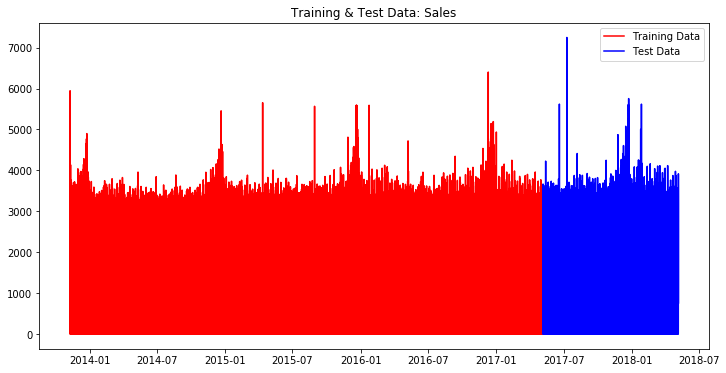

In [35]:
# split the data into training and validation set
train = df_sales_hourly[['value']].loc['2013-11-07 13:00:00': '2017-05-05 19:00:00']
test = df_sales_hourly[['value']].loc['2017-05-05 20:00:00': '2018-05-06 19:00:00']
plt.plot(train['value'], label = 'Training Data', color = 'red')
plt.plot(test['value'], label = 'Test Data', color = 'blue')
plt.title('Training & Test Data: Sales')
plt.legend()

In [36]:
# transform the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train)

scaled_train = sc.transform(train)
scaled_test = sc.transform(test[['value']])

X_train = scaled_train[: -1]
y_train = scaled_train[1: ]

X_test = scaled_test[: -1]
y_test = scaled_test[1: ]

In [37]:
## Evaluation metric: mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred, breakdown = False):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if breakdown:
        mape = (np.abs((y_true - y_pred) / y_true)) * 100
    else:
        mape = np.mean((np.abs((y_true - y_pred) / y_true)) * 100)
    return mape

### Naive: Sales Data

In [38]:
y_true_sales = y_test[1: ].copy()
y_true_sales

array([[-0.85093715],
       [-0.9426768 ],
       [-0.95663718],
       ...,
       [ 1.07160687],
       [ 1.14672702],
       [-0.46935338]])

In [39]:
y_pred_sales = y_test[: -1].copy()
y_pred_sales

array([[ 0.01660087],
       [-0.85093715],
       [-0.9426768 ],
       ...,
       [ 1.26771699],
       [ 1.07160687],
       [ 1.14672702]])

In [40]:
# test the model
mape_sales_naive = mean_absolute_percentage_error(y_true_sales, y_pred_sales)
mape_sales_naive

902.6213626575955

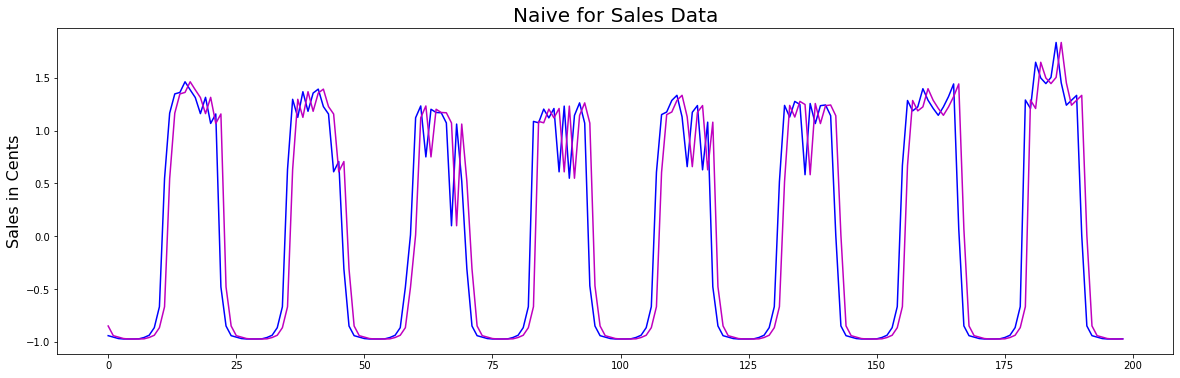

In [41]:
plt.figure(figsize = (20, 6))
plt.title('Naive for Sales Data', fontsize = 20)
plt.ylabel('Sales in Cents', fontsize = 16)
plt.plot(y_true_sales[1: 200], color = 'blue')
plt.plot(y_pred_sales[1: 200], color = 'm')

Naive model is just the shift version of the data. 

In [42]:
# create reports for sales data
reports_sales = pd.DataFrame(columns = ['Target', 'Method', 'MAPE'])
reports_sales

,Target,Method,MAPE


In [43]:
# reports for Sales data using Naive
reports_sales.loc[len(reports_sales)] = ['Sales', 'Naive', mape_sales_naive]
reports_sales

,Target,Method,MAPE
0,Sales,Naive,902.621363


### LSTM: Sales Data

In [44]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import keras.backend as K

In [45]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [46]:
# Fit the model

np.random.seed(1)
K.clear_session()

model = Sequential()
model.add(LSTM(20, activation = 'relu', input_shape = (1, 1)))
model.add(Dense(1))
model.compile(optimizer = Adam(), loss = 'mse')
model.fit(X_train_t, y_train, 
          validation_data = (X_test_t, y_test),
         epochs = 50,
         verbose = 1)


Epoch 1/50
957/957 [==============================] - 1s 1ms/step - loss: 0.3379 - val_loss: 0.2183
Epoch 2/50
957/957 [==============================] - 1s 973us/step - loss: 0.2175 - val_loss: 0.2144
Epoch 3/50
957/957 [==============================] - 1s 996us/step - loss: 0.2154 - val_loss: 0.2120
Epoch 4/50
957/957 [==============================] - 1s 980us/step - loss: 0.2145 - val_loss: 0.2104
Epoch 5/50
957/957 [==============================] - 1s 1ms/step - loss: 0.2139 - val_loss: 0.2096
Epoch 6/50
957/957 [==============================] - 1s 1ms/step - loss: 0.2135 - val_loss: 0.2095
Epoch 7/50
957/957 [==============================] - 1s 1ms/step - loss: 0.2131 - val_loss: 0.2093
Epoch 8/50
957/957 [==============================] - 1s 982us/step - loss: 0.2129 - val_loss: 0.2085
Epoch 9/50
957/957 [==============================] - 1s 1ms/step - loss: 0.2127 - val_loss: 0.2080
Epoch 10/50
957/957 [==============================] - 1s 1ms/step - loss: 0.2126 - val_loss

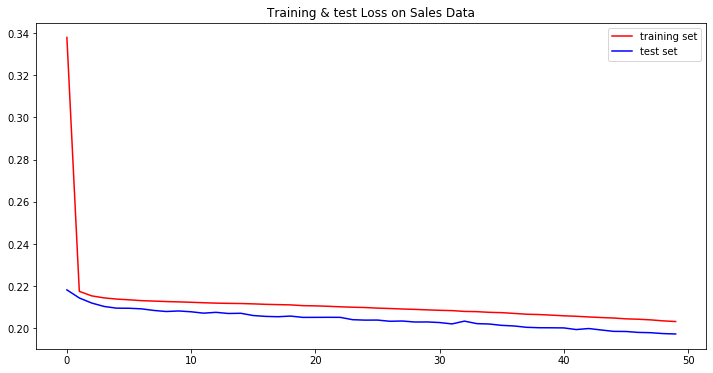

In [47]:
plt.plot(model.history.history['loss'], label = 'training set', color = 'red')
plt.plot(model.history.history['val_loss'], label = 'test set', color = 'blue')
plt.title('Training & test Loss on Sales Data')
plt.legend()
plt.show()

The problem about LSTM is that the test loss drops below the training loss, indicating the problems of overfitting to the data. 

In [48]:
# Predict 

X_test_LSTM = np.insert(X_test, 0, X_train[-1][0]).reshape(-1, 1)
X_test_LSTM = X_test_LSTM[:, None]
X_test_LSTM.shape

predictions_sales_LSTM = model.predict(X_test_LSTM)
predictions_sales = pd.DataFrame(predictions_sales_LSTM, columns = ['LSTM_Sales'])

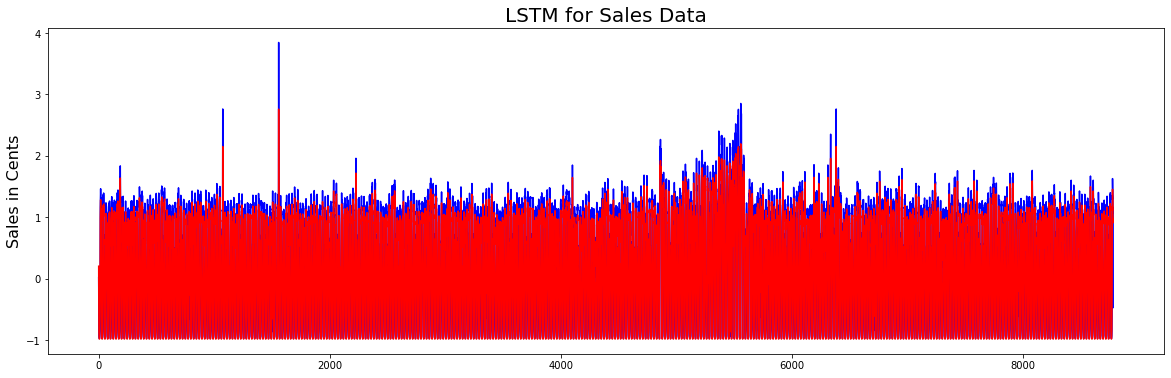

In [50]:
# Plot the predictions

plt.figure(figsize = (20, 6))
plt.title('LSTM for Sales Data', fontsize = 20)
plt.ylabel('Sales in Cents', fontsize = 16)
plt.plot(y_test, color = 'blue')
plt.plot(predictions_sales.shift(-2), color = 'red')

In [52]:
# test the model
mape_sales_lstm = mean_absolute_percentage_error(y_test[: -1], predictions_sales.shift(-2)[: -2])
mape_sales_lstm

162.10475392400525

In [53]:
# reports for Sales data using LSTM
reports_sales.loc[len(reports_sales)] = ['Sales', 'LSTM', mape_sales_lstm]
reports_sales

,Target,Method,MAPE
0,Sales,Naive,902.621363
1,Sales,LSTM,162.104754


From the plot, the prediction is following the trend of the data closely and doing a great job in prediction. From the comparison of the MAPE, LSTM is doing a great job.

> **Traffic**

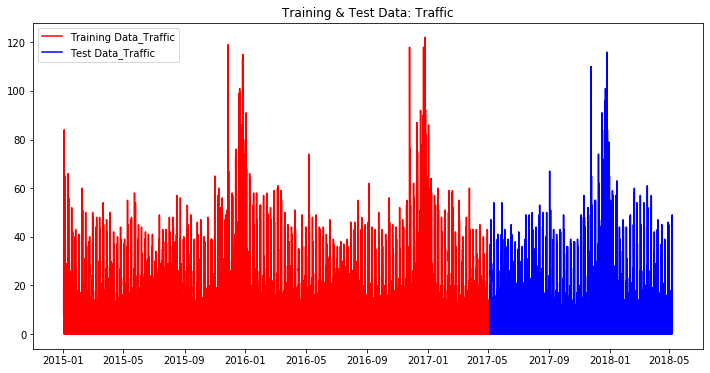

In [54]:
# split the data into training and validation set
train_traffic = df_traffic_hourly[['value']].loc['2015-01-01 10:00:00': '2017-05-05 19:00:00']
test_traffic = df_traffic_hourly[['value']].loc['2017-05-05 20:00:00': '2018-05-06 21:00:00']

plt.plot(train_traffic['value'], label = 'Training Data_Traffic', color = 'red')
plt.plot(test_traffic['value'], label = 'Test Data_Traffic', color = 'blue')
plt.title('Training & Test Data: Traffic')
plt.legend()

In [55]:
# transform the data 
sc = StandardScaler()
sc.fit(train_traffic)

scaled_train_traffic = sc.transform(train_traffic)
scaled_test_traffic = sc.transform(test_traffic[['value']])

X_train_traffic = scaled_train_traffic[: -1]
y_train_traffic = scaled_train_traffic[1: ]

X_test_traffic = scaled_test_traffic[: -1]
y_test_traffic = scaled_test_traffic[1: ]

### Naive: Traffic Data

In [56]:
y_true_traffic = y_test_traffic[1: ].copy()
y_true_traffic

array([[-0.635136  ],
       [-0.635136  ],
       [-0.635136  ],
       ...,
       [-0.33591754],
       [ 0.03810554],
       [-0.56033138]])

In [57]:
y_pred_traffic = y_test_traffic[: -1].copy()
y_pred_traffic

array([[-0.56033138],
       [-0.635136  ],
       [-0.635136  ],
       ...,
       [ 0.41212861],
       [-0.33591754],
       [ 0.03810554]])

In [58]:
# test the model
mape_traffic_naive = mean_absolute_percentage_error(y_true_traffic, y_pred_traffic)
mape_traffic_naive

90.47009111999228

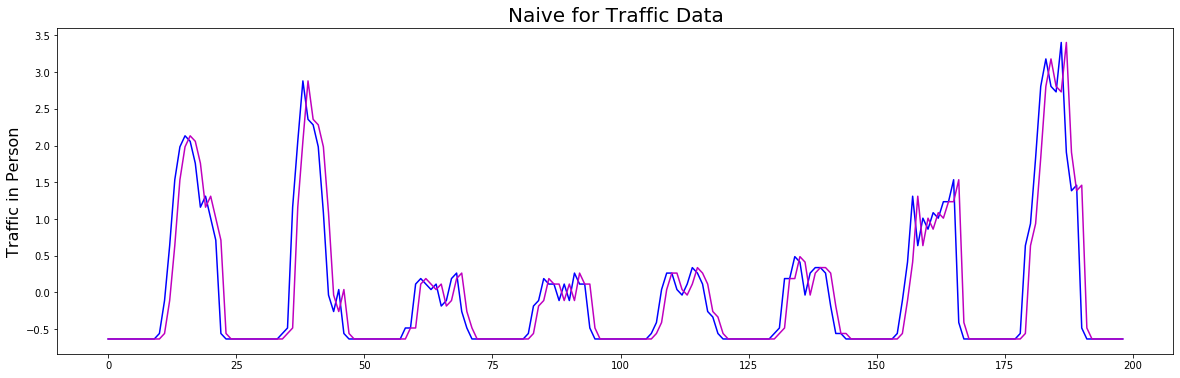

In [59]:
plt.figure(figsize = (20, 6))
plt.title('Naive for Traffic Data', fontsize = 20)
plt.ylabel('Traffic in Person', fontsize = 16)
plt.plot(y_true_traffic[1: 200], color = 'blue')
plt.plot(y_pred_traffic[1: 200], color = 'm')

In [60]:
# test the model
mape_traffic_naive = mean_absolute_percentage_error(y_true_traffic, y_pred_traffic)
mape_traffic_naive

90.47009111999228

In [61]:
# create reports for traffic data
reports_traffic = pd.DataFrame(columns = ['Target', 'Method', 'MAPE'])
reports_traffic

,Target,Method,MAPE


In [62]:
# reports for Sales data using Naive
reports_traffic.loc[len(reports_traffic)] = ['Sales', 'Naive', mape_traffic_naive]
reports_traffic

,Target,Method,MAPE
0,Sales,Naive,90.470091


### LSTM: Traffic Data

In [63]:
X_train_t_traffic = X_train_traffic[:, None]
X_test_t_traffic = X_test_traffic[:, None]

In [64]:
# Fit the model

np.random.seed(1)
K.clear_session()

model = Sequential()
model.add(LSTM(20, activation = 'relu', input_shape = (1, 1)))
model.add(Dense(1))
model.compile(optimizer = Adam(), loss = 'mse')
model.fit(X_train_t_traffic, 
          y_train_traffic, 
          validation_data = (X_test_t_traffic, y_test_traffic),
          epochs = 50,
          verbose = 1)

Epoch 1/50
642/642 [==============================] - 1s 1ms/step - loss: 0.3420 - val_loss: 0.1742
Epoch 2/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1719 - val_loss: 0.1734
Epoch 3/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1711 - val_loss: 0.1741
Epoch 4/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1713 - val_loss: 0.1728
Epoch 5/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1704 - val_loss: 0.1727
Epoch 6/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1703 - val_loss: 0.1722
Epoch 7/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1700 - val_loss: 0.1720
Epoch 8/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1695 - val_loss: 0.1724
Epoch 9/50
642/642 [==============================] - 1s 936us/step - loss: 0.1691 - val_loss: 0.1713
Epoch 10/50
642/642 [==============================] - 1s 1ms/step - loss: 0.1687 - val_loss: 0.17

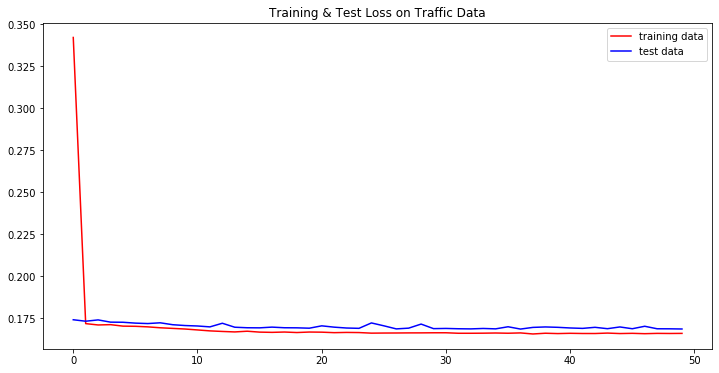

In [65]:
# Plot the training & test loss
plt.plot(model.history.history['loss'], label = 'training data', color = "red")
plt.plot(model.history.history['val_loss'], label = 'test data', color = "blue")
plt.title('Training & Test Loss on Traffic Data')
plt.legend()
plt.show()

In [66]:
# Predict 

X_test_LSTM_traffic = np.insert(X_test_traffic, 0, X_train_traffic[-1][0]).reshape(-1, 1)
X_test_LSTM_traffic = X_test_LSTM_traffic[:, None]
X_test_LSTM_traffic.shape

predictions_LSTM = model.predict(X_test_LSTM_traffic)
predictions_LSTM_traffic = pd.DataFrame(predictions_LSTM)

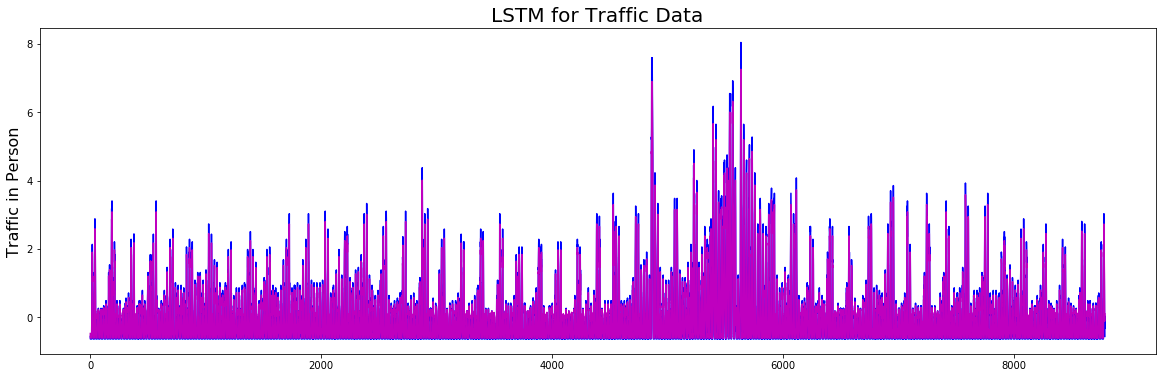

In [67]:
# Plot the predictions

plt.figure(figsize = (20, 6))
plt.title('LSTM for Traffic Data', fontsize = 20)
plt.ylabel('Traffic in Person', fontsize = 16)
plt.plot(y_test_traffic, color = 'blue')
plt.plot(predictions_LSTM_traffic.shift(-2), color = 'm')

In [68]:
# MAPE for traffic data
mape_traffic_lstm = mean_absolute_percentage_error(y_test_traffic[: -1], predictions_LSTM_traffic.shift(-2)[: -2])
mape_traffic_lstm

27.327305698274298

In [69]:
# reports for traffic data 
reports_traffic.loc[len(reports_traffic)] = ['Traffic', 'LSTM', mape_traffic_lstm]
reports_traffic

,Target,Method,MAPE
0,Sales,Naive,90.470091
1,Traffic,LSTM,27.327306


In [70]:
reports_sales

,Target,Method,MAPE
0,Sales,Naive,902.621363
1,Sales,LSTM,162.104754


# Report

- ## Data 
In the project, only two given datasets were used. Sales.csv contains data from `2013-11-07 13:00:00` to `2018-05-06 19:00:00`, with `39391` hours ; `Traffic.csv` contains data from `2015-01-01 10:00:00` to `2018-05-06 21:00:00` data with `29316` hours.

- ## Handling Missing Data 
Because both two datasets show clear seasonality, I replaced the missing data points (value = 0) with the mean of corresponding hours. 

- ## Model Selection
I implement **Naive model (S_(t) = S_(t - 1))** as reference for both two datasets, and univariate **LSTM** model. It shows that LSTM is capturing the trend of the dataset, and predict the values well. But, for Sales data, test loss is lower than training loss, which raises the issue of **overfitting**. 

- ## Future Work
**parameter tuning** and other models including **multivariate LSTM**, **multivariate SARIMAX**, **XGBoost**, **Ensemble model** combining with more variables like **weather**, **Temperature**, **Unemployment**, etc. and other technologies with **NLP** to help predict more correctly and eventually help **better schedule associates at different stores**.